### Théo Cornille - Luc Gibaud - Cédric des Lauriers

# Débruitage d'image : BM3D, implémentations et expérimentations

### Rappel des consignes : 

Le livrable contiendra typiquement :
- une partie implémentation (partielle ou totale)
- une partie expérimentale (avec des résultats d'expérience)
- un rapport qui décrit :
    - le travail effectué
    - la problématique
    - donne le pseudo code de l'algorithme
    - présente les résultats expérimentaux
    - donne une analyse critique


Il faudra rendre les travaux avant le 07/01/2019 *au plus tard*. 

### Source utilisées : 
- https://www.ipol.im/pub/art/2012/l-bm3d/article.pdf
- http://mcolom.perso.math.cnrs.fr/download/articles/acta_numerica.pdf?fbclid=IwAR23wScDWCFEZhrtUWb7j1tI6xjOyUpUoEa8_EEbM2mFjxiKhGljBGHs_4o
- https://www.ipol.im/pub/art/2013/16/article.pdf (Comparaison entre BM3D et non-local Bayes)

- https://github.com/liuhuang31/BM3D-Denoise/blob/master/BM3D.py


### Lien overleaf : 
- https://www.overleaf.com/6472126525mqdrghptnykh


## I. Implémentation
### a) BM3D - Etape 1

In [1]:
# Si nécessaire, pour installer cv2 : !pip install opencv-python

In [1]:
#Import des librairies nécessaires
import numpy as np
import cv2

In [2]:
# Fonction qui définit la distance quadratique entre deux "patches"
dist = lambda a, b, k : np.linalg.norm(a - b)**2 / (k**2)

In [3]:
# Selectionne la zone de recherche
def select_search_zone(u_noised, row, column, n_rows, n_columns, lambda_):
    row_min = 0 if row - lambda_//2 < 0 else row - lambda_//2
    row_max = n_rows if row + lambda_//2 + lambda_%2 > n_rows else row + lambda_//2 + lambda_%2
    column_min = 0 if column - lambda_//2 < 0 else column - lambda_//2
    column_max = n_columns if column + lambda_//2 + lambda_%2 > n_columns else column + lambda_//2 + lambda_%2
    return u_noised[row_min : row_max, column_min : column_max]

In [4]:
#Défini la fonction gamma utilisée dans la première étape de BM3D
def gamma(x, lambda_3D, sigma):
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if np.abs(x[i,j]) <= lambda_3D * sigma:     # lambda_3D* sigma : Threshold for Hard Thresholding
                x[i,j] = 0
    return x

In [59]:
# La première étape de débruitage
def BM3D_first_part(u_noised, sigma, k = 8, lambda_ = 39, N_max = 16, s= 3 , lambda_3D = 2.7):

    n_rows, n_columns = u_noised.shape
    
    V = np.zeros((u_noised.shape[0], u_noised.shape[1]))
    DELTA = np.zeros((u_noised.shape[0], u_noised.shape[1]))
    u_denoised = np.zeros((u_noised.shape[0], u_noised.shape[1]))
    
    #k = 8 # Block size 
    #lambda_ = 39 # Search Window 
    #N_max = 16 # max matched block 
    #s = 3 # Search Step
    #lambda_3D = 2.7 # for hard thresholding
    
    #k, lambda_, N_max, s, lambda_3D  = 8, 39, 16, 3 ,2.7
    
    tau = 5000 if sigma > 40 else 2500   # BUG peut aussi venir d ici , mais bug quand meme pour  sigma = 40 voir en bas 
    
    for row in range(k//2, n_rows - k//2 - k%2 + 1, s):
        for column in range(k//2, n_columns - k//2 - k%2 + 1, s):
            P = u_noised[row - k//2 : row + k//2 + k%2, column - k//2 : column + k//2 + k%2]

            # Grouping
            search_zone = select_search_zone(u_noised, row, column, n_rows, n_columns, lambda_)
            L = []
            for i in range(search_zone.shape[0] - k):
                for j in range(search_zone.shape[1] - k):
                    Q = search_zone[i : i  + k, j : j + k]
                    dist_ = dist(P,Q,k)
                    if dist_ < tau:
                        L.append((Q, dist_))
            L.sort(key = lambda x : x[1])
            if len(L) > N_max:
                N_chosen = N_max
            else :
                p = 0
                while 2**(p+1) <= len(L):
                    p +=1
                N_chosen = 2**p
                
            # ICI le BUG  rien ne se met dans la list L (tableau vide )
            # aucun block ne match 
            #print(N_chosen)
            #print(np.array(L[:N_chosen]).shape)
            group_3D = np.array(L[:N_chosen])[:,0]  
                
            # Collaborative Filtering
            for i in range(len(group_3D)):
                tau_3D = cv2.dct(group_3D[i].astype(np.float64))
                group_3D[i] = cv2.idct(gamma(tau_3D, lambda_3D, sigma))
            
            # Aggregation
            for Q in group_3D:
                for i in range(Q.shape[0]):
                    for j in range(Q.shape[1]):
                        V[row - k//2 + i, column - k//2 + j] += Q[i, j]/ max(N_chosen, 1)
                        DELTA[row - k//2 + i, column - k//2 + j] += 1./ max(N_chosen, 1)
            
    u_denoised = (V / DELTA)
    
    return u_denoised

### b) BM3D - Etape 2

In [55]:
# La seconde étape de débruitage
def BM3D_second_part(u_noised, u_basic, sigma, k = 8, lambda_= 39, N_max = 32, s= 3):
    
    n_rows, n_columns = u_noised.shape
    
    V = np.zeros((u_noised.shape[0], u_noised.shape[1]))
    DELTA = np.zeros((u_noised.shape[0], u_noised.shape[1]))
    u_denoised = np.zeros((u_noised.shape[0], u_noised.shape[1]))
    
    #k = 8  # block size
    #lambda_= 39 # Serach window
    #N_max = 32 # max matche block
    #s = 3 # search step 
    
    #k, lambda_, N_max, s  = 8, 39, 32, 3
    
    tau = 3500 if sigma > 40 else 400
    
    for row in range(k//2, n_rows - k//2 - k%2 + 1, s):
        for column in range(k//2, n_columns - k//2 - k%2 + 1, s):
            P = u_noised[row - k//2 : row + k//2 + k%2, column - k//2 : column + k//2 + k%2]
            P_basic = u_basic[row - k//2 : row + k//2 + k%2, column - k//2 : column + k//2 + k%2]

            # Grouping
            search_zone_basic = select_search_zone(u_basic, row, column, n_rows, n_columns, lambda_)
            search_zone = select_search_zone(u_noised, row, column, n_rows, n_columns, lambda_)
            L_basic = []
            L = []
            for i in range(search_zone_basic.shape[0] - k):
                for j in range(search_zone_basic.shape[1] - k):
                    Q = search_zone_basic[i : i  + k, j : j + k]
                    dist_ = dist(P_basic,Q,k)
                    if dist_ < tau:
                        L_basic.append((Q, dist_))
                        L.append((search_zone[i : i  + k, j : j + k], dist_))
            L_basic.sort(key = lambda x : x[1])
            L.sort(key = lambda x : x[1])
            if len(L_basic) > N_max: 
                N_chosen = N_max
            else :
                p = 0
                while 2**(p+1) <= len(L):
                    p +=1
                N_chosen = 2**p
            group_3D_basic = np.array(L_basic[:N_chosen])[:,0]  
            group_3D = np.array(L[:N_chosen])[:,0]
                
            # Collaborative Filtering
            Wp = []
            P_wien = []
            for i in range(len(group_3D)):          
                tau_wien_basic = cv2.dct(group_3D_basic[i].astype(np.float64))
                tau_wien = cv2.dct(group_3D[i].astype(np.float64))
                Wp.append(tau_wien_basic**2 / (tau_wien_basic**2 + sigma**2))
                P_wien.append(cv2.idct(Wp[-1] * tau_wien))
                
            # Aggregation
            for n in range(len(group_3D)):
                Q = P_wien[n]
                for i in range(Q.shape[0]):
                    for j in range(Q.shape[1]): 
                        V[row - k//2 + i, column - k//2 + j] += Q[i, j]/ np.linalg.norm(Wp[n])**2
                        DELTA[row - k//2 + i, column - k//2 + j] += 1./ np.linalg.norm(Wp[n])**2
                        
    u_denoised = (V / DELTA)     
            
    return u_denoised

### c) BM3D - Algorithme général

In [57]:
# L'algorithme général
def BM3D(u_noised, sigma):
    
    u_denoised_after_step1 = BM3D_first_part(u_noised, sigma)
    u_denoised = BM3D_second_part(u_noised, u_denoised_after_step1, sigma)
    
    return u_denoised

## II. Expérimentation

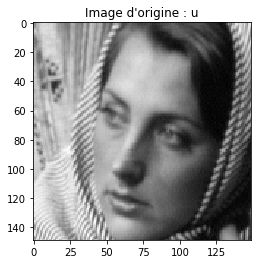

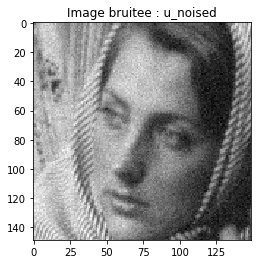

In [8]:
import matplotlib.pyplot as plt

# On importe u une image sans bruit
u = (plt.imread("barbara.png") * 255).astype(int)[25:174, 300:449]
plt.imshow(u, plt.cm.gray)
plt.title("Image d'origine : u")
plt.show()

u_shape = u.shape

# On crée artificiellement du bruit avec un écart-type de 5 (sigma = 5)
np_round = np.vectorize(lambda x : int(round(x,0)))
u_noised = u + np_round(np.random.normal(0, 10, ((u.shape[0], u.shape[1]))))
plt.imshow(u_noised, plt.cm.gray)
plt.title("Image bruitee : u_noised")
plt.show()

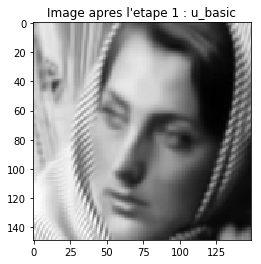

In [9]:
u_basic = BM3D_first_part(u_noised, 10) # sigma = 10 car l'écart-type = 10

plt.imshow(u_basic, plt.cm.gray)
plt.title("Image apres l'etape 1 : u_basic")
plt.show()

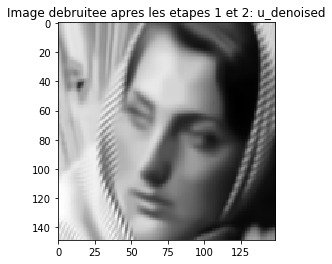

In [10]:
u_denoised = BM3D_second_part(u_noised, u_basic, 10) # sigma = 10 car l'écart-type = 10

plt.imshow(u_denoised, plt.cm.gray)
plt.title("Image debruitee apres les etapes 1 et 2: u_denoised")
plt.show()

In [18]:
#https://www.researchgate.net/profile/Nirvair_Neeru/publication/271156596_Performance_Comparison_of_Various_Image_Denoising_Filters_under_Spatial_Domain/links/577f554e08ae5f367d3553ad/Performance-Comparison-of-Various-Image-Denoising-Filters-under-Spatial-Domain.pdf
import numpy 
import math
import cv2

def mse(img1, img2):
    D = numpy.array(img1 - img2, dtype=numpy.int64)
    D[:, :] = D[:, :]**2
    RMSE = D.sum()/img1.size
    return RMSE


def psnr(img1, img2):
    D = numpy.array(img1 - img2, dtype=numpy.int64)
    D[:, :] = D[:, :]**2
    RMSE = D.sum()/img1.size
    psnr = 10*math.log10(float(255.**2)/RMSE)
    return psnr

In [12]:
def print_experiment(u, u_noised, u_denoised):
    original =  u  #cv2.imread("original.png")
    noised = u_noised #cv2.imread("photoshopped.png",1)
    denoised = u_denoised
    psnr_ori_noised =psnr(original,noised)
    psnr_ori_denoised = psnr(original,denoised)
    psnr_noised_denoised = psnr(u_noised,denoised)
    mse_ori_noised = mse(original,noised)
    mse_ori_denoised = mse(original,denoised)
    mse_noised_denoised=  mse(u_noised,denoised)
    print("PSNR entre image originale et bruitée: ", psnr_ori_noised)
    print("PSNR entre image originale et débruitée: ", psnr_ori_denoised)
    #print("PSNR entre image bruitée et débruitée: ", psnr_noised_denoised)
    #print("MSE entre image originale et bruitée: ", mse_ori_noised)
    #print("MSE entre image originale et débruitée: ", mse_ori_denoised)
    #print("MSE entre image bruitée et débruitée: ", mse_noised_denoised)

def plot_image(u, u_noised, u_denoised):
    plt.imshow(u, plt.cm.gray)
    plt.title("Image d'origine : u")
    plt.show()
    plt.imshow(u_noised, plt.cm.gray)
    plt.title("Image bruitée : u_noised")
    plt.show()
    plt.imshow(u_denoised, plt.cm.gray)
    plt.title("Image débruitée: u_denoised")
    plt.show()


In [14]:
import skimage
from skimage.util import random_noise
speckle_im = random_noise(u, mode='speckle', seed=None, clip=True)
u_speckle_denoised = BM3D(speckle_im, 0.1)
print_experiment(u, speckle_im, u_speckle_denoised)

D:\Programmes\Anaconda2\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars
D:\Programmes\Anaconda2\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars


PSNR entre image originale et bruitée:  5.80557830732277
PSNR entre image originale et débruitée:  29.267392975673307


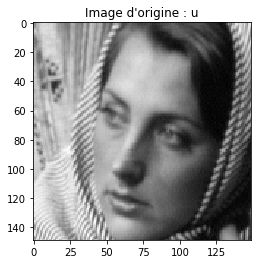

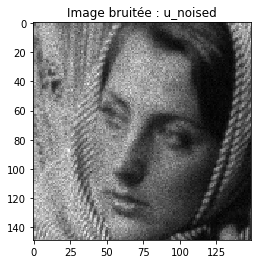

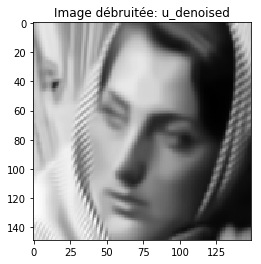

In [15]:
plot_image(u, speckle_im  ,u_speckle_denoised)

PSNR entre image originale et bruitée:  25.39020644515592
PSNR entre image originale et débruitée:  24.49277207277443


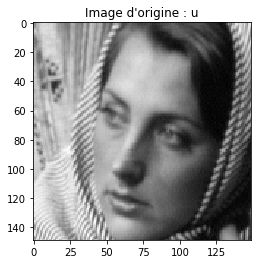

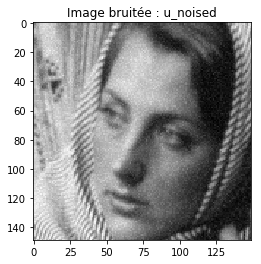

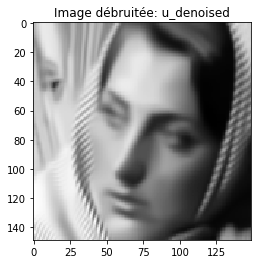

In [60]:
u_noised_rayleigh =  u + np.random.rayleigh(10, (u.shape))
u_rayleigh_denoised = BM3D(u_noised_rayleigh,10)
print_experiment(u, u_noised_rayleigh , u_rayleigh_denoised)
plot_image(u, u_noised_rayleigh, u_rayleigh_denoised)

PSNR entre image originale et bruitée:  28.537177127765524
PSNR entre image originale et débruitée:  29.381933640544972


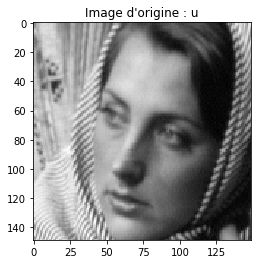

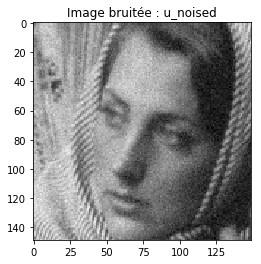

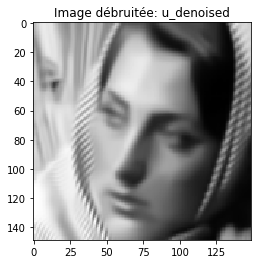

In [16]:
u_noised_gauss =  u + np.random.normal(0,10,(u.shape))
u_gauss_denoised = BM3D(u_noised_gauss,10)
print_experiment(u, u_noised_gauss , u_gauss_denoised)
plot_image(u, u_noised_gauss, u_gauss_denoised)

In [54]:
# Resultats bruit gaussien 
list_sigma = [39, 100]   #[2,5,10,20,30,40,60,80,100]
def result_exp(list_sigma, img):
    res_psnr = []
    res_mse =[]
    
    for sigma in list_sigma:
        img_gauss =  img + np.random.normal(0,sigma,(img.shape))
        
        # replace extreme value due to noise 
        img_gauss[img_gauss < 0] = 0
        img_gauss[img_gauss>255] = 255
        print(img_gauss)
        img_gauss_denoised = BM3D(img_gauss,sigma)
        psnr_before_denoising = psnr(img,img_gauss)
        mse_before_denosing = mse(img,img_gauss)
        psnr_after_denoising = psnr(img,img_gauss_denoised)
        mse_after_denosing = mse(img,img_gauss_denoised)
        
        # premier sans débruitage, deuxieme avec 
        res_psnr.append((psnr_before_denoising,psnr_after_denoising ))
        res_mse.append((mse_before_denosing,mse_after_denosing ))
        
        if sigma == 2 or sigma == 30 or sigma == 100:
            print("sigma = " , sigma )
            plot_image(img, img_gauss, img_gauss_denoised)
            
    return res_psnr, res_mse
      

In [53]:
res_psnr, res_mse = result_exp(list_sigma, u)

[[141.89862371 118.64611701 159.59193921 ... 163.78007121 144.71799178
  189.28915346]
 [115.57145391 154.38208922 130.35610633 ... 142.2293936  229.44080527
  225.11788471]
 [127.92557532 124.10328836 143.85518684 ... 133.27824738 141.24172139
  201.4552145 ]
 ...
 [244.34106847 179.97170643 129.53184685 ... 135.80616244  20.75294028
   70.12458202]
 [200.85731142 146.99709569 189.87575904 ... 151.87973925   9.29776264
   59.27224353]
 [172.76700812 113.17934726 255.         ... 161.99880237  79.96017612
   90.07995365]]
4
(4, 2)
16
(16, 2)
16
(16, 2)
8
(8, 2)
1
(1, 2)
2
(2, 2)
1
(1, 2)
8
(8, 2)
4
(4, 2)
4
(4, 2)
4
(4, 2)
4
(4, 2)
8
(8, 2)
16
(16, 2)
8
(8, 2)
8
(8, 2)
16
(16, 2)
2
(2, 2)
1
(1, 2)
1
(1, 2)
2
(2, 2)
2
(2, 2)
8
(8, 2)
16
(16, 2)
8
(8, 2)
8
(8, 2)
16
(16, 2)
16
(16, 2)
16
(16, 2)
4
(4, 2)
1
(1, 2)
4
(4, 2)
16
(16, 2)
16
(16, 2)
16
(16, 2)
16
(16, 2)
16
(16, 2)
16
(16, 2)
16
(16, 2)
8
(8, 2)
4
(4, 2)
16
(16, 2)
16
(16, 2)
4
(4, 2)
1
(1, 2)
2
(2, 2)
2
(2, 2)
1
(0,)


IndexError: too many indices for array


# Influence des paramètres 
on va ici faire varier certains des paramètres clés de l'algorithme BM3D

on fixe pour cela sigma = 10 (bien qu'on puisse le faire sur un ensemble de sigma plus exhaustif) 
### Nombre de patches maximum retenu N_max  par défault : 16 (I), 32 (II)
où N_max le nombre de patch maximum retenus 


In [64]:
list_N_1 =[8,16,32,64]
list_N_2 = [8,16,32,64]
sigma = 10 
def grid_N(img, img_noised, list_N_1, list_N_2, sigma):
    dict ={}
    for N_1 in list_N_1:
        for N_2 in list_N_2:
            u_denoised_after_step1 = BM3D_first_part(img_noised, sigma , 8,  39, N_1, 3 , 2.7)
            u_denoised = BM3D_second_part(img_noised, u_denoised_after_step1, sigma,  8, 39, N_2,  3)
            psnr_res = psnr(img,u_denoised)
            dict[(N_1, N_2)] = psnr_res
    return dict 

u_noised_gauss =  u + np.random.normal(0,10,(u.shape))

dict_res= grid_N(u, u_noised_gauss , list_N_1, list_N_2, 10)        
    

In [65]:
dict_res 

{(8, 8): 31.553732480975654,
 (8, 16): 30.6304556734881,
 (8, 32): 29.617839920271983,
 (8, 64): 28.686019123375214,
 (16, 8): 31.203724606995237,
 (16, 16): 30.313979049972936,
 (16, 32): 29.302829389324998,
 (16, 64): 28.35014453721252,
 (32, 8): 30.70688334633873,
 (32, 16): 29.875647469738883,
 (32, 32): 28.88149266857051,
 (32, 64): 27.889100172913714,
 (64, 8): 30.04018168150639,
 (64, 16): 29.30206079499381,
 (64, 32): 28.382133174177287,
 (64, 64): 27.29173487883349}

In [66]:
### lambda_3D (hard thresholding)
list_lambda_3D =[2.5,2.7,3.0,3.2]

sigma = 10 
def grid_lambda_3D(img, img_noised, list_lambda_3D, sigma):
    dict ={}
    for lambda_3D in list_lambda_3D:
        
        u_denoised_after_step1 = BM3D_first_part(img_noised, sigma , 8,  39, 16, 3 , lambda_3D)
        u_denoised = BM3D_second_part(img_noised, u_denoised_after_step1, sigma,  8, 39, 32,  3)
        psnr_res = psnr(img,u_denoised)
        dict[lambda_3D] = psnr_res
    return dict 

u_noised_gauss =  u + np.random.normal(0,10,(u.shape))

dict_res_lambda_3D= grid_lambda_3D(u, u_noised_gauss , list_lambda_3D, 10)        
dict_res_lambda_3D    

{2.5: 29.334614307660104,
 2.7: 29.279657217497142,
 3.0: 29.204676760843924,
 3.2: 29.157240019594287}

In [ ]:
#BM3D_first_part(u_noised, sigma, k = 8, lambda_ = 39, N_max = 16, s= 3 , lambda_3D = 2.7)
# BM3D_second_part(u_noised, u_basic, sigma, k = 8, lambda_= 39, N_max = 32, s= 3)

In [ ]:
# k taille des patches 
list_k_1 =[4,6,8,10,12]
list_k_2 = [4,6,8,10,12]
sigma = 10 
def grid_k(img, img_noised, list_k_1, list_k_2, sigma):
    dict ={}
    
    for k_1 in list_k_1:
        for k_2 in list_k_2:
            try : 
                u_denoised_after_step1 = BM3D_first_part(img_noised, sigma , k_1,  39, 16, 3 , 2.7)
                u_denoised = BM3D_second_part(img_noised, u_denoised_after_step1, sigma,  k_2, 39, 32,  3)
                psnr_res = psnr(img,u_denoised)
                dict[(k_1, k_2)] = psnr_res
            except :
                dict[(k_1, k_2)] = 0

    return dict 

u_noised_gauss =  u + np.random.normal(0,10,(u.shape))

dict_res_k= grid_k(u, u_noised_gauss , list_k_1, list_k_2, 10)        
dict_res_k

D:\Programmes\Anaconda2\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
D:\Programmes\Anaconda2\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


In [70]:
# s step_size
list_s_1 = [1,3,5]
list_s_2= [1,3,5]

sigma = 10 
def grid_s(img, img_noised, list_s_1, list_s_2, sigma):
    dict ={}
    for s_1 in list_s_1:
        for s_2 in list_s_2:
            try: 
                
                u_denoised_after_step1 = BM3D_first_part(img_noised, sigma , 8,  39, 16, s_1 , 2.7)
                u_denoised = BM3D_second_part(img_noised, u_denoised_after_step1, sigma,  8, 39, 32,  s_2)
                psnr_res = psnr(img,u_denoised)
                dict[(s_1,s_2)] = psnr_res
            except : 
                dict[(s_1,s_2)] = 0
    return dict 

u_noised_gauss =  u + np.random.normal(0,10,(u.shape))

dict_res_s= grid_s(u, u_noised_gauss , list_s_1, list_s_2, 10)        
dict_res_s




D:\Programmes\Anaconda2\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide
D:\Programmes\Anaconda2\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


{(1, 1): 29.434110972738345,
 (1, 3): 29.355542594251638,
 (1, 5): 29.705606769265316,
 (3, 1): 29.418173716794264,
 (3, 3): 29.33288278258404,
 (3, 5): 29.701745894051086,
 (5, 1): 0,
 (5, 3): 0,
 (5, 5): 29.599012065531355}

## Test du BM3D par rapport à des techniques de débruitages "plus simple"
#### Pour sigma = 10 on obtient 29.38 de PSNR avec BM3D
#### et 32.46 de PSNR avec NL Bayes 

PSNR entre image originale et bruitée:  28.497105520144682
PSNR entre image originale et débruitée:  25.975970461989665


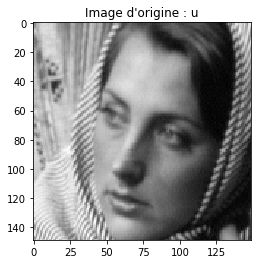

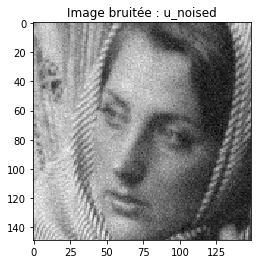

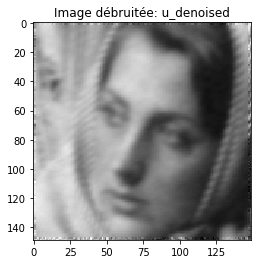

In [106]:
#https://docs.scipy.org/doc/scipy/reference/ndimage.html
# Resultat de notre implémentation BM3D 29.38 PSNR   NLBAYES 32.46 

# On utilise un filtre median pour débruiter 
from scipy.ndimage import median_filter
u_noised_gauss =  u + np.random.normal(0,10,(u.shape))
u_median_gauss= median_filter(u_noised_gauss, size=2, footprint=None, output=None, mode='reflect', cval=0.0, origin=0)
print_experiment(u, u_noised_gauss , u_median_gauss)
plot_image(u, u_noised_gauss, u_mean_gauss )


PSNR entre image originale et bruitée:  28.43849024767385
PSNR entre image originale et débruitée:  22.41171183461608


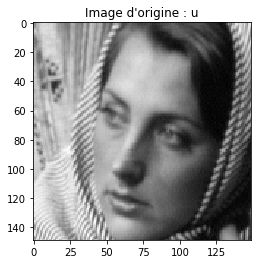

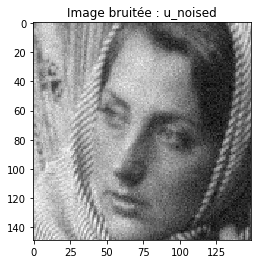

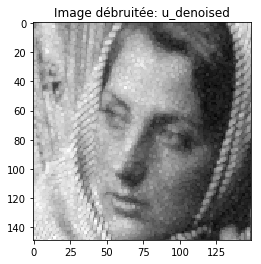

In [111]:
# filtre maximum
from scipy.ndimage import maximum_filter
u_noised_gauss =  u + np.random.normal(0,10,(u.shape))
u_max_gauss= maximum_filter(u_noised_gauss, size=2, footprint=None, output=None, mode='reflect', cval=0.0, origin=0)
print_experiment(u, u_noised_gauss , u_max_gauss)
plot_image(u, u_noised_gauss, u_max_gauss )

PSNR entre image originale et bruitée:  28.472736364564977
PSNR entre image originale et débruitée:  20.209031483513517


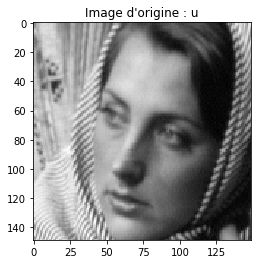

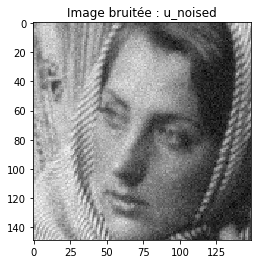

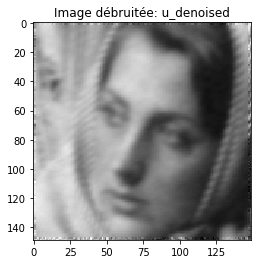

In [109]:
# filtre gaussien 
from scipy.ndimage import gaussian_filter
# pour sigma = 10 
u_noised_gauss =  u + np.random.normal(0,10,(u.shape))
u_denoised_gauss = gaussian_filter(u_noised_gauss, 10, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
print_experiment(u, u_noised_gauss , u_denoised_gauss)
plot_image(u, u_noised_gauss, u_mean_gauss )
